In [2]:
import pandas as pd  # For data manipulation
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data and hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier  # For building the Random Forest model
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  # For model evaluation
from imblearn.over_sampling import SMOTE  # For handling class imbalance
import joblib  # For saving the model and scaler
from sklearn.model_selection import cross_val_score  # Import this to use cross_val_score
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns  # For better visualization
from sklearn.metrics import roc_curve, roc_auc_score  # For ROC curve and AUC
import numpy as np  #




In [3]:
# Load the dataset
url = 'AlzheimerClinicalDataset.csv'  # Replace with the URL of your CSV file
data = pd.read_csv(url)

# Separate features and target variable
X = data.drop('Diagnosis', axis=1)  # Features
y = data['Diagnosis']  # Target
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)


In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)


In [5]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           verbose=2,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [7]:
# Best parameters and score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Accuracy: {grid_search.best_score_}')

# Initialize the best model
best_rf_model = grid_search.best_estimator_

# Train the best Random Forest model
best_rf_model.fit(X_train, y_train)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy: 0.786525057641852


RandomForestClassifier(min_samples_split=5, random_state=42)

In [8]:
# Evaluate the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test)

# Print evaluation metrics for Random Forest
print('Random Forest Model Evaluation:')
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2f}')


Random Forest Model Evaluation:
[[318 101]
 [ 74 341]]
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       419
           1       0.77      0.82      0.80       415

    accuracy                           0.79       834
   macro avg       0.79      0.79      0.79       834
weighted avg       0.79      0.79      0.79       834

Accuracy: 0.79


In [9]:
# Cross-validation scores for Random Forest
cv_scores_rf = cross_val_score(best_rf_model, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f'Random Forest Cross-Validation Accuracy Scores: {cv_scores_rf}')
print(f'Random Forest Mean Accuracy: {cv_scores_rf.mean():.2f}')


Random Forest Cross-Validation Accuracy Scores: [0.77697842 0.74640288 0.74280576 0.85045045 0.82882883]
Random Forest Mean Accuracy: 0.79


In [ ]:
# Save the model and scaler
joblib.dump(best_rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

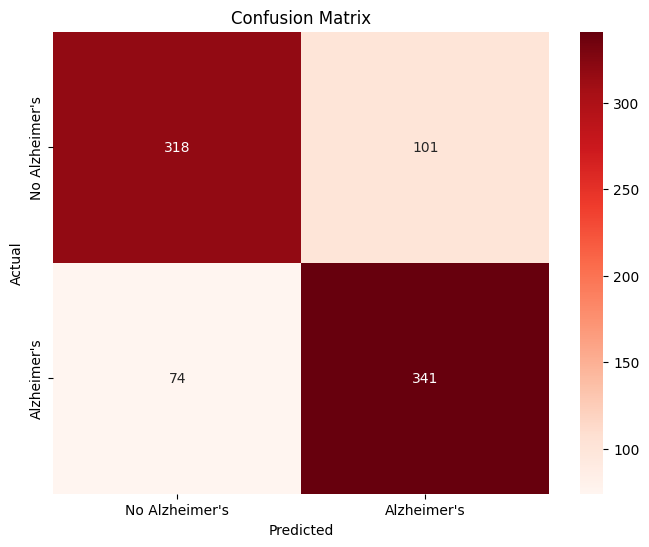

In [10]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Alzheimer\'s', 'Alzheimer\'s'],
            yticklabels=['No Alzheimer\'s', 'Alzheimer\'s'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


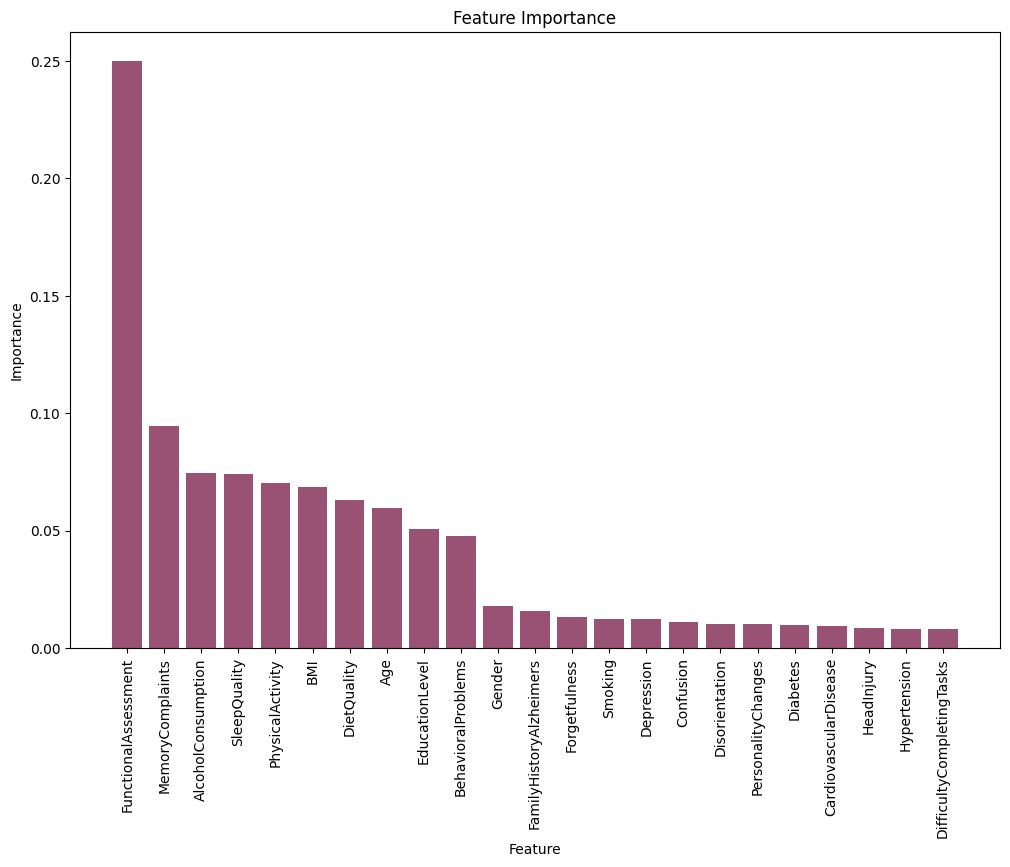

FunctionalAssessment: 0.25
MemoryComplaints: 0.09
AlcoholConsumption: 0.07
SleepQuality: 0.07
PhysicalActivity: 0.07
BMI: 0.07
DietQuality: 0.06
Age: 0.06
EducationLevel: 0.05
BehavioralProblems: 0.05
Gender: 0.02
FamilyHistoryAlzheimers: 0.02
Forgetfulness: 0.01
Smoking: 0.01
Depression: 0.01
Confusion: 0.01
Disorientation: 0.01
PersonalityChanges: 0.01
Diabetes: 0.01
CardiovascularDisease: 0.01
HeadInjury: 0.01
Hypertension: 0.01
DifficultyCompletingTasks: 0.01


In [12]:
# Feature Importance Visualization
feature_importances = best_rf_model.feature_importances_
features = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title('Feature Importance')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center', color='#995174')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
for i in indices:
    print(f'{features[i]}: {feature_importances[i]:.2f}')


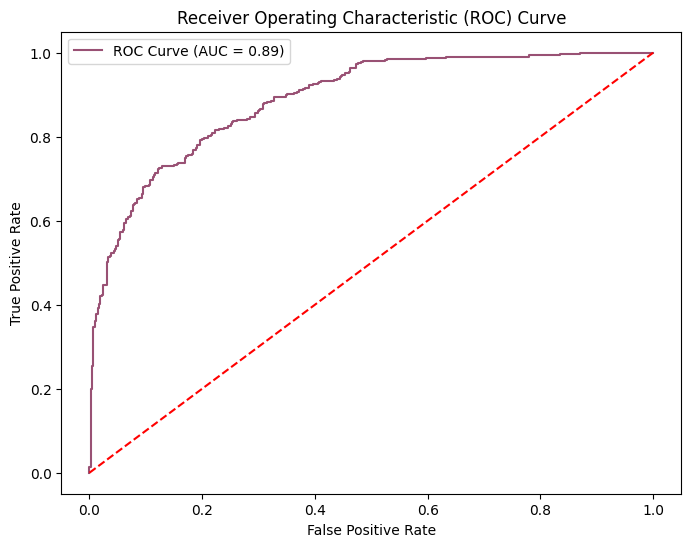

In [ ]:
# ROC Curve and AUC Score Visualization
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc_score = roc_auc_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#995174', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
